In [1]:
import numpy as np
import pandas as pd
from CONSTANTS import KEYS, MONTHS, YEARS, EXP_DATES, TARGET_COLUMN, FUTCODES_AND_STRIKESTEPS, N_STRIKES, CALL_PUT
import parse_csvs
import realised_volatility
import implied_volatility
import bs_model
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

In [2]:
CV = TimeSeriesSplit()
SCORER = 'neg_root_mean_squared_error'
RND = np.random.RandomState(12345)

In [3]:
KEY = KEYS[0]
NAME_RI = KEY + '-' + MONTHS[3] + '.' + YEARS[21]
START_DATE = '2022-09-15'
EXP_DATE = '2022-12-15'
STRIKE_STEP = FUTCODES_AND_STRIKESTEPS[KEY]

In [4]:
NAME_RI, NAME_RI[4:]

('RTS-12.22', '12.22')

In [5]:
EXP_DATES[NAME_RI[4:]]['qrt'][0]

'151222'

In [10]:
def options_df(lower, upper, exp_date):
    options_df = pd.DataFrame()
    for strike in range(lower - N_STRIKES * STRIKE_STEP, upper + (N_STRIKES + 1) * STRIKE_STEP, STRIKE_STEP):
        for call_put in CALL_PUT:
            name = NAME_RI + 'M' + exp_date + call_put + 'A' + str(strike)
            result, data = parse_csvs.parse(name)
            try:
                data = data[[TARGET_COLUMN]]
                #data = data[data.index >= START_DATE]
            except:
                pass
            try:
                data['strike'] = strike
            except:
                pass
            try:
                data['option_type'] = CALL_PUT[call_put]
            except:
                pass
            options_df = pd.concat([options_df, data])
    return options_df

In [4]:
def compute_ivs(row):
    for moneyness_strike in MONEYNESS_STRIKES:
        row[moneyness_strike] = (round(row['adjp'] / STRIKE_STEP) * STRIKE_STEP +
                                  (MONEYNESS_STRIKES[moneyness_strike] * STRIKE_STEP))
        
        for call_put in OPT_MONTHS_CODES:
            prem_column_name = moneyness_strike + '_prem_' + call_put
            sigma_column_name = moneyness_strike + '_sigma_' + call_put
            iv_column_name = moneyness_strike + '_iv_' + call_put
            
            row[prem_column_name] = options_df[(options_df.index == row.name) & 
                                  (options_df['strike'] == row[moneyness_strike]) & 
                                  (options_df['option_type'] == call_put)]['adjp'][0]
            row[sigma_column_name] = iterate_iv.iterate_iv(row['adjp'], row[moneyness_strike], row['T'], call_put, 
                                                    row[prem_column_name])
            row[iv_column_name] = row[sigma_column_name] * 100
            
    return row

In [5]:
def vola_smile_df(data):
    vola_smile_call = pd.DataFrame()
    vola_smile_put = pd.DataFrame()
    vola_smile_call['till_exp'] = data['till_exp']
    vola_smile_put['till_exp'] = data['till_exp']
    for moneyness_strike in MONEYNESS_STRIKES:
        iv_column_name_call = moneyness_strike + '_iv_' + 'call'
        iv_column_name_put = moneyness_strike + '_iv_' + 'put'
        vola_smile_call[iv_column_name_call] = data[iv_column_name_call]
        vola_smile_put[iv_column_name_put] = data[iv_column_name_put]
    vola_smile_call.set_index('till_exp', inplace = True)
    vola_smile_put.set_index('till_exp', inplace = True)
    
    return vola_smile_call, vola_smile_put

In [6]:
result, riu2 = parse_csvs.parse(NAME_RI)

In [7]:
result

{'name': 'RTS-12.22',
 'columns': True,
 'to_datetime': True,
 'sort_values': True,
 'set_index': True,
 'read_scv': True}

In [8]:
riu2.index = riu2.index.to_period("D")

In [9]:
riu2 = riu2[[TARGET_COLUMN]]

In [10]:
riu2 = realised_volatility.compute(riu2)

In [11]:
#fut_qrt = fut_qrt[fut_qrt.index >= START_DATE]

In [12]:
#fut_qrt = fut_qrt.dropna()

In [13]:
riu2.tail()

,adjp,sin_day,mov_5,lag_1
date,,,,
2022-12-09,109890,0.958718,110230.0,109720.0
2022-12-12,109130,0.615285,109730.0,109890.0
2022-12-13,109050,0.440519,109590.0,109130.0
2022-12-14,106740,0.247022,108906.0,109050.0
2022-12-15,103915,0.043022,107745.0,106740.0


In [14]:
riu2.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 510 entries, 2020-12-11 to 2022-12-15
Freq: D
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   adjp     510 non-null    int64  
 1   sin_day  510 non-null    float64
 2   mov_5    506 non-null    float64
 3   lag_1    509 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 19.9 KB


In [15]:
riu2.isna().sum().sort_values(ascending = False)

mov_5      4
lag_1      1
adjp       0
sin_day    0
dtype: int64

In [16]:
riu2.describe()

,adjp,sin_day,mov_5,lag_1
count,510.000000,510.000000,506.000000,509.000000
mean,132374.754902,-0.013826,132486.179842,132430.667976
std,24596.471695,0.704724,24484.232462,24588.204504
min,78260.000000,-0.999250,83416.000000,78260.000000
25%,111010.000000,-0.705584,111250.500000,111040.000000
50%,135655.000000,0.043022,135961.000000,135700.000000
75%,153382.500000,0.735417,153370.000000,153410.000000
max,182690.000000,0.996659,180864.000000,182690.000000


In [17]:
riu2.index.is_monotonic

True

<AxesSubplot:xlabel='date'>

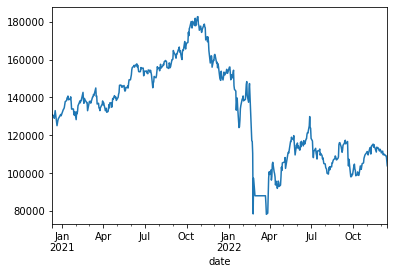

In [18]:
riu2[TARGET_COLUMN].plot()

In [19]:
try:
    riu2['return'].plot()
except:
    print('no return plot')

no return plot


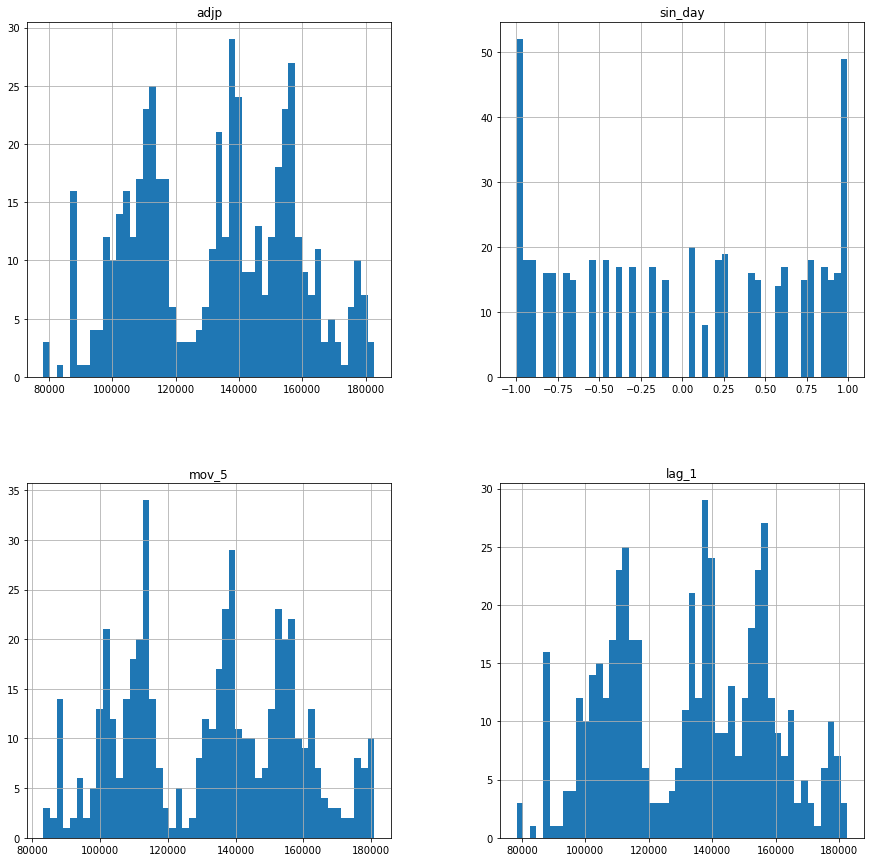

In [20]:
riu2.hist(bins = 50, figsize = (15, 15))
plt.show()

In [21]:
try:
    riu2['volatility_5'].plot()
except:
    print('no vol_5')

no vol_5


In [22]:
try:
    riu2['volatility_20'].plot()
except:
    print('no vol_20')

no vol_20


In [23]:
try:
    riu2['volatility_60'].plot()
except:
    print('no vol_60')

no vol_60


Подготовка к обучению

Аппроксимация линейной регрессией.

In [24]:
model = LinearRegression()

Дамми модели:

In [25]:
y = riu2[TARGET_COLUMN]

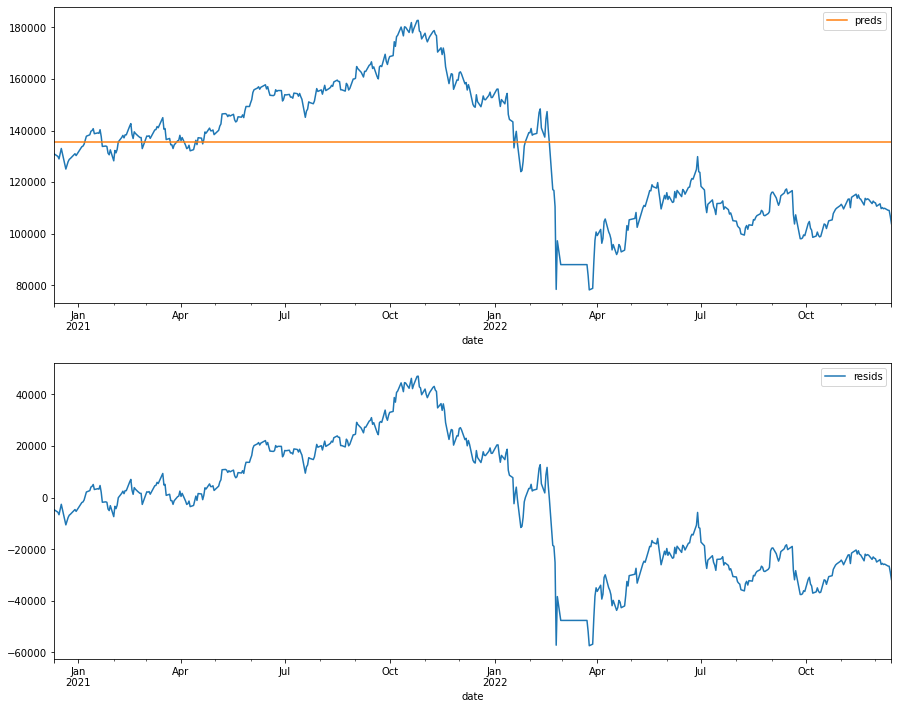

24572.35, 20964.93
0.0


In [26]:
preds_mean = pd.DataFrame(np.ones(y.shape[0]) * y.mean(), index = y.index, columns = ['preds'])
preds_median = pd.DataFrame(np.ones(y.shape[0]) * y.median(), index = y.index, columns = ['preds'])
fig, ax = plt.subplots(2, figsize = (15, 12))
y.plot(ax = ax[0])
preds_median.plot(ax = ax[0])
(y - preds_median['preds']).plot(ax = ax[1], label = 'resids')
plt.legend()
plt.show()
print('{:.2f}, {:.2f}'.format(mean_squared_error(y, preds_mean)**0.5,
                              mean_absolute_error(y, preds_median)))
print(r2_score(y, preds_mean))

Используем шаг по времени:

In [27]:
y = riu2[TARGET_COLUMN]

In [28]:
X = riu2[['time_step']]
model.fit(X, y)
preds = pd.DataFrame(model.predict(X), index = X.index, columns = ['preds'])
fig, ax = plt.subplots(2, figsize = (15, 12))
y.plot(ax = ax[0], legend = True)
preds.plot(ax = ax[0])
(y - preds['preds']).plot(ax = ax[1], label = 'resids')
plt.legend()
plt.show()
print('{:.2f}, {:.2f}'.format(mean_squared_error(y, preds)**0.5,
                              mean_absolute_error(y, preds)))
print(r2_score(y, preds))

KeyError: "None of [Index(['time_step'], dtype='object')] are in the [columns]"

ЛР с лагом

In [29]:
y = riu2[TARGET_COLUMN]

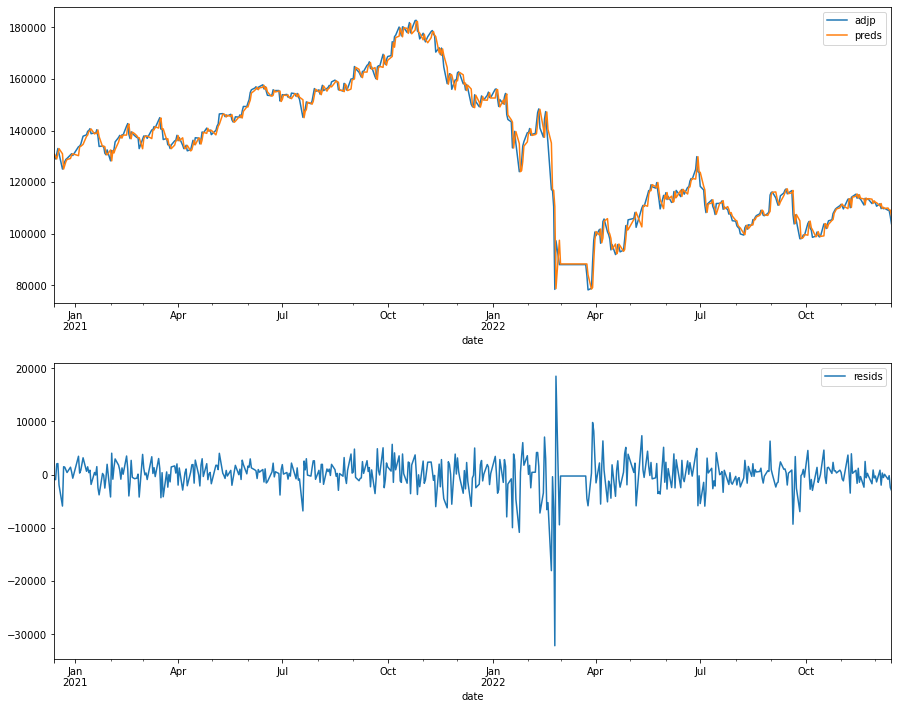

3169.37, 1999.97
0.983396317444711


In [30]:
X = riu2[['lag_1']].dropna()
y, X = y.align(X, join='inner', axis = 0)
model.fit(X, y)
preds = pd.DataFrame(model.predict(X), index = X.index, columns = ['preds'])
fig, ax = plt.subplots(2, figsize = (15, 12))
y.plot(ax = ax[0], legend = True)
preds.plot(ax = ax[0])
(y - preds['preds']).plot(ax = ax[1], label = 'resids')
plt.legend()
plt.show()
print('{:.2f}, {:.2f}'.format(mean_squared_error(y, preds)**0.5,
                              mean_absolute_error(y, preds)))
print(r2_score(y, preds))

<AxesSubplot:>

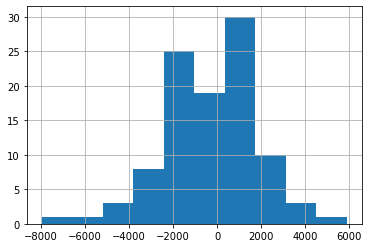

In [115]:
(y - preds['preds']).hist()

In [116]:
(y - preds['preds']).describe()

count     101.000000
mean     -338.011311
std      2072.835607
min     -7947.694527
25%     -1581.760922
50%      -318.295607
75%       997.514331
max      5871.695792
dtype: float64

Применим скользящие средние:

In [31]:
y = riu2[TARGET_COLUMN]

In [32]:
X = riu2[['mov_5']]

In [33]:
X = X.dropna()

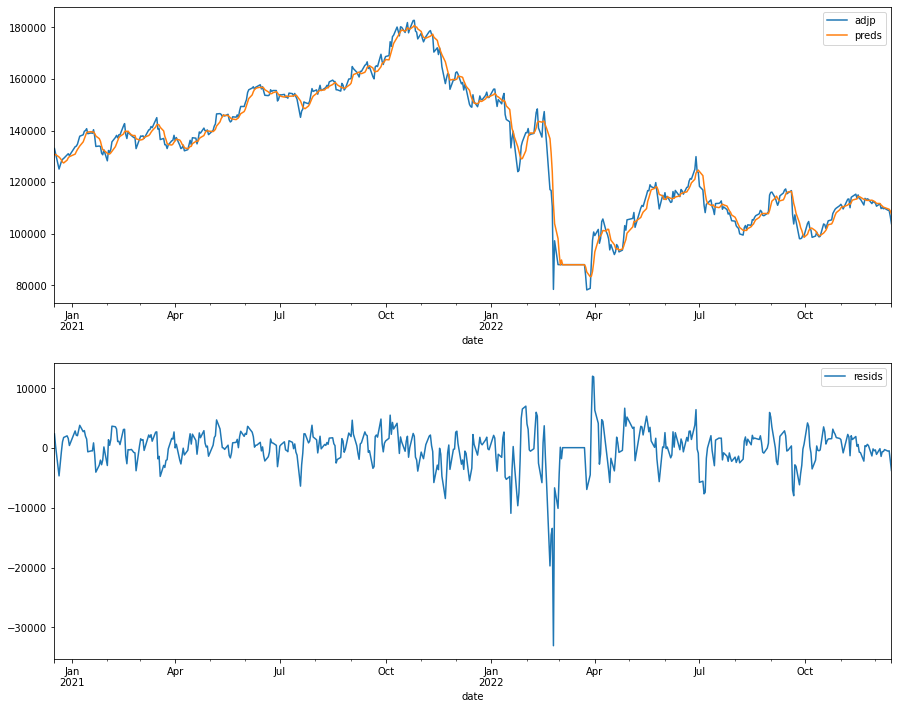

3351.82, 2172.86
0.9815379724957318


In [34]:
y, X = y.align(X, join='inner', axis = 0)
model.fit(X, y)
preds = pd.DataFrame(model.predict(X), index = X.index, columns = ['preds'])
fig, ax = plt.subplots(2, figsize = (15, 12))
y.plot(ax = ax[0], legend = True)
preds.plot(ax = ax[0])
(y - preds['preds']).plot(ax = ax[1], label = 'resids')
plt.legend()
plt.show()
print('{:.2f}, {:.2f}'.format(mean_squared_error(y, preds)**0.5,
                              mean_absolute_error(y, preds)))
print(r2_score(y, preds))

Применим Determenistic process

In [35]:
y = riu2[TARGET_COLUMN]

In [36]:
dp = DeterministicProcess(
    index = y.index,  # dates from the training data
    constant = True,       # dummy feature for the bias (y_intercept)
    order = 1,             # the time dummy (trend)
    drop = True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

In [37]:
model.fit(X, y)
preds = pd.DataFrame(model.predict(X), index = X.index, columns = ['preds'])

In [38]:
X = dp.out_of_sample(steps=60)

In [39]:
y_fore = pd.DataFrame(model.predict(X), index = X.index, columns = ['forecast'])

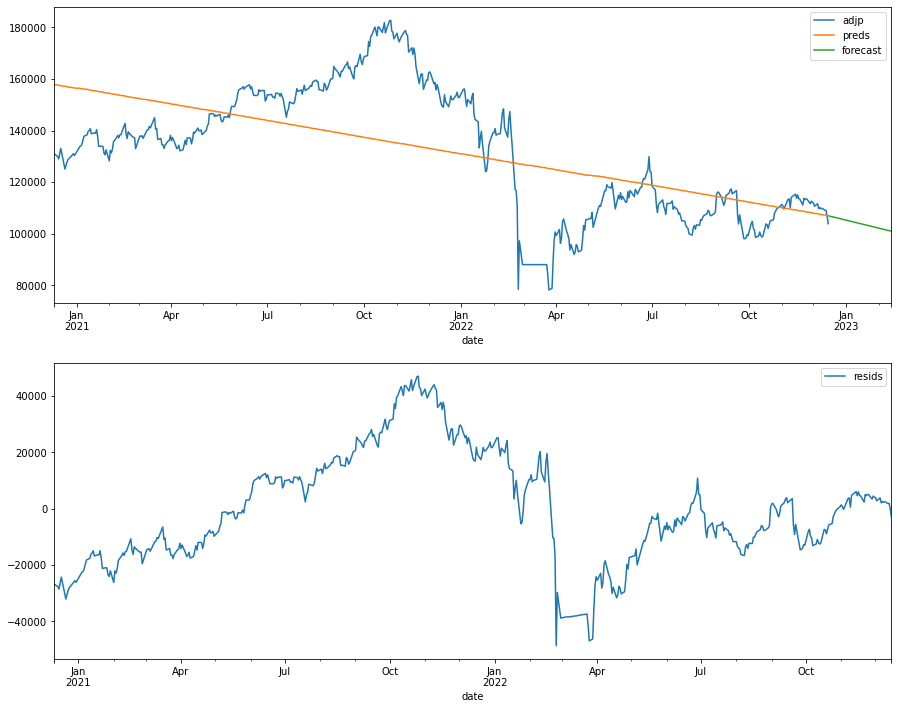

19699.97, 15952.76
0.35725606568346735


In [40]:
fig, ax = plt.subplots(2, figsize = (15, 12))
y.plot(ax = ax[0], legend = True)
preds.plot(ax = ax[0])
y_fore.plot(ax = ax[0])
(y - preds['preds']).plot(ax = ax[1], label = 'resids')
plt.legend()
plt.show()
print('{:.2f}, {:.2f}'.format(mean_squared_error(y, preds)**0.5,
                              mean_absolute_error(y, preds)))
print(r2_score(y, preds))

Переходим к Фурье

In [41]:
y = riu2[TARGET_COLUMN]

In [42]:
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)

In [43]:
fourier = fourier_features(y, freq=365, order=4)

<AxesSubplot:xlabel='adjp'>

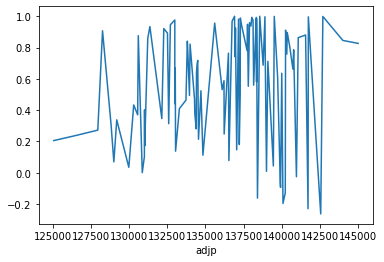

In [44]:
fourier.iloc[:100, 2].sort_index().plot()

In [45]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

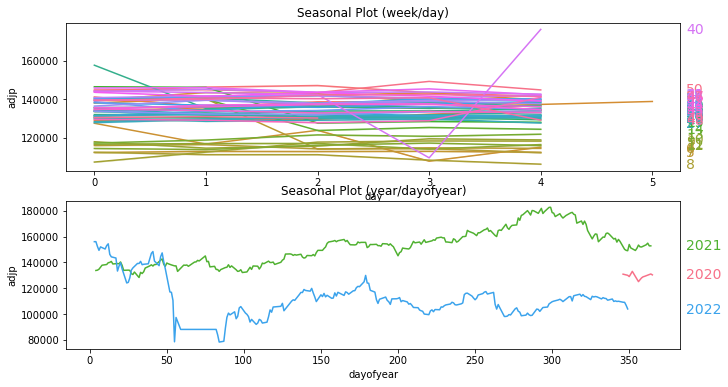

In [46]:
X = riu2.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y=TARGET_COLUMN, period="week", freq="day", ax=ax0)
seasonal_plot(X, y=TARGET_COLUMN, period="year", freq="dayofyear", ax=ax1);

In [47]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

/var/folders/lp/88x61zk54x96rfk1cnvrknb80000gn/T/ipykernel_44646/3030094478.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  plot_periodogram(y)


<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

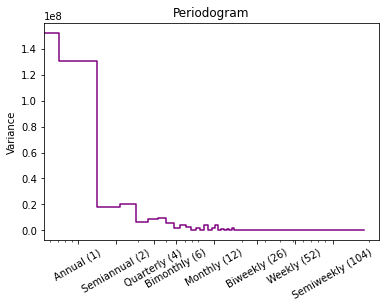

In [48]:
plot_periodogram(y)

In [49]:
fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

In [50]:
fourier

Fourier(freq=A-DEC, order=10) at 0x7fd252d03130

In [51]:
dp = DeterministicProcess(
    index=y.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()

In [52]:
X.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 510 entries, 2020-12-11 to 2022-12-15
Freq: D
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   const               510 non-null    float64
 1   trend               510 non-null    float64
 2   s(2,7)              510 non-null    float64
 3   s(3,7)              510 non-null    float64
 4   s(4,7)              510 non-null    float64
 5   s(5,7)              510 non-null    float64
 6   s(6,7)              510 non-null    float64
 7   s(7,7)              510 non-null    float64
 8   sin(1,freq=A-DEC)   510 non-null    float64
 9   cos(1,freq=A-DEC)   510 non-null    float64
 10  sin(2,freq=A-DEC)   510 non-null    float64
 11  cos(2,freq=A-DEC)   510 non-null    float64
 12  sin(3,freq=A-DEC)   510 non-null    float64
 13  cos(3,freq=A-DEC)   510 non-null    float64
 14  sin(4,freq=A-DEC)   510 non-null    float64
 15  cos(4,freq=A-DEC)   510 non-null

<AxesSubplot:xlabel='date'>

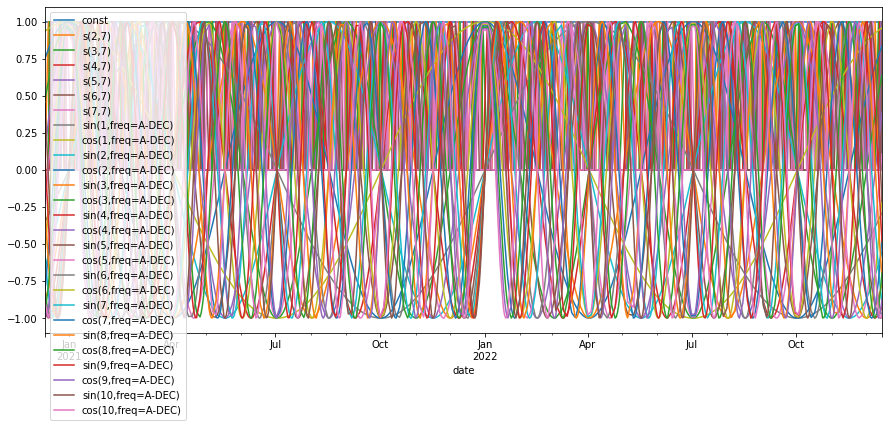

In [53]:
X.drop('trend', axis = 1).plot(figsize = (15, 6))

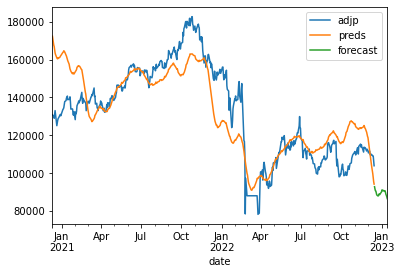

In [54]:
model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

preds = pd.Series(model.predict(X), index=X.index)
X_fore = dp.out_of_sample(steps=30)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot()
ax = preds.plot(ax=ax, label="preds")
ax = y_fore.plot(ax=ax, label="forecast")
_ = ax.legend()

<AxesSubplot:xlabel='date'>

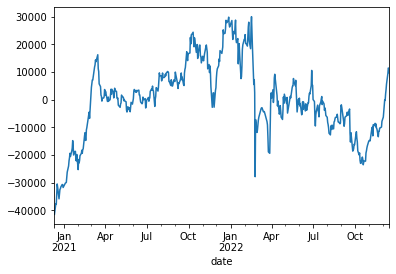

In [55]:
deseased = (y - preds)
deseased.plot()

In [56]:
print('{:.2f}, {:.2f}'.format(mean_squared_error(y, preds)**0.5,
                              mean_absolute_error(y, preds)))
print(r2_score(y, preds))

13599.75, 10388.84
0.6936846114203712


/var/folders/lp/88x61zk54x96rfk1cnvrknb80000gn/T/ipykernel_44646/3892376015.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  plot_periodogram(deseased)


<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

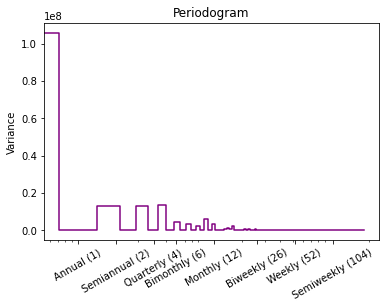

In [57]:
plot_periodogram(deseased)

In [58]:
riu2['target'] = riu2[TARGET_COLUMN].shift(-1)

In [59]:
riu2.dropna(inplace = True)

In [60]:
riu2.drop(TARGET_COLUMN,axis = 1, inplace = True)

In [61]:
riu2.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 505 entries, 2020-12-17 to 2022-12-14
Freq: D
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   sin_day  505 non-null    float64
 1   mov_5    505 non-null    float64
 2   lag_1    505 non-null    float64
 3   target   505 non-null    float64
dtypes: float64(4)
memory usage: 19.7 KB


In [62]:
features = riu2.drop('target', axis = 1)
target = riu2['target']
features.columns

Index(['sin_day', 'mov_5', 'lag_1'], dtype='object')

In [85]:
features.shape, target.shape

((505, 3), (505,))

In [86]:
features

,sin_day,mov_5,lag_1
date,,,
2020-12-17,-0.361714,130786.0,131010.0
2020-12-18,-0.545240,130818.0,133050.0
2020-12-21,-0.930724,129836.0,131030.0
2020-12-22,-0.985948,129348.0,125080.0
2020-12-23,-0.999250,128738.0,126570.0
...,...,...,...
2022-12-08,0.996659,110390.0,110160.0
2022-12-09,0.958718,110230.0,109720.0
2022-12-12,0.615285,109730.0,109890.0


In [87]:
target

date
2020-12-17    131030.0
2020-12-18    125080.0
2020-12-21    126570.0
2020-12-22    127960.0
2020-12-23    128830.0
                ...   
2022-12-08    109890.0
2022-12-09    109130.0
2022-12-12    109050.0
2022-12-13    106740.0
2022-12-14    103915.0
Freq: D, Name: target, Length: 505, dtype: float64

In [88]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

In [89]:
model = LinearRegression()

In [90]:
model.fit(X_train, y_train)

LinearRegression()

In [91]:
X_train.columns

Index(['sin_day', 'mov_5', 'lag_1'], dtype='object')

In [92]:
model.coef_

array([9.68335111e+02, 3.08682556e-01, 6.79129083e-01])

In [93]:
preds = model.predict(X_test)

In [94]:
print('{:.2f}, {:.2f}'.format(mean_squared_error(y_test, preds)**0.5,
                              mean_absolute_error(y_test, preds)))
print(r2_score(y_test, preds))

3005.79, 2286.07
0.6851820342702266


In [102]:
categorical_features = []

In [103]:
numeric_features = ['sin_day', 'mov_5', 'lag_1']

In [104]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('OHE', OneHotEncoder(drop='first', handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
])

In [105]:
lr_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('estimator', LinearRegression())])

In [106]:
lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['sin_day', 'mov_5',
                                                   'lag_1']),
                                                 ('cat',
                                                  Pipeline(steps=[('OHE',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  [])])),
                ('estimator', LinearRegression())])

In [107]:
preds = pd.DataFrame(lr_pipe.predict(X_test), index = X_test.index, columns = ['preds'])
resids = pd.DataFrame(y_test - preds['preds'], index = y_test.index, columns = ['resids'])

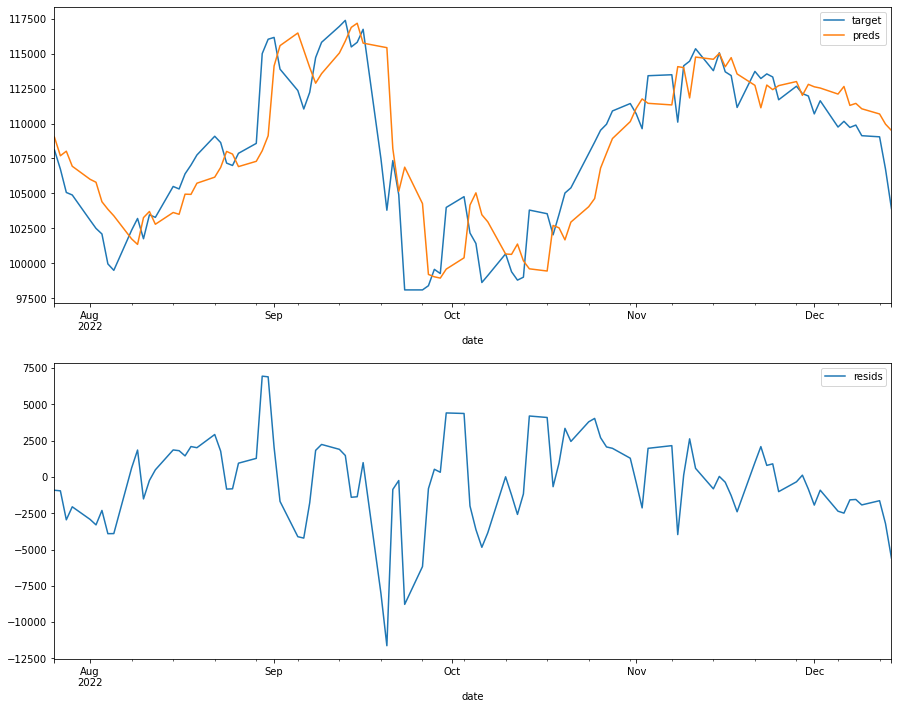

3005.79, 2286.07
0.6851820342702268


In [109]:
fig, ax = plt.subplots(2, figsize = (15, 12))
y_test.plot(ax = ax[0], legend = True)
preds.plot(ax = ax[0])
resids.plot(ax = ax[1], label = 'resids')
plt.legend()
plt.show()
print('{:.2f}, {:.2f}'.format(mean_squared_error(y_test, preds)**0.5,
                              mean_absolute_error(y_test, preds)))
print(r2_score(y_test, preds))

array([[<AxesSubplot:title={'center':'resids'}>]], dtype=object)

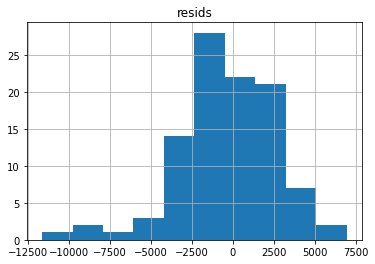

In [110]:
resids.hist()

In [111]:
resids.describe()

,resids
count,101.000000
mean,-374.694480
std,2997.216126
min,-11627.694527
25%,-1937.726079
50%,-362.485669
75%,1833.905695
max,6946.166056


In [112]:
resids.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 101 entries, 2022-07-26 to 2022-12-14
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   resids  101 non-null    float64
dtypes: float64(1)
memory usage: 1.6 KB


/var/folders/lp/88x61zk54x96rfk1cnvrknb80000gn/T/ipykernel_44646/3651888821.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  plot_periodogram(resids['resids'])


<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

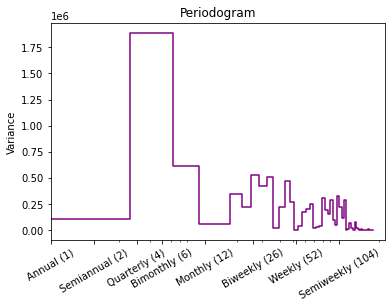

In [113]:
plot_periodogram(resids['resids'])

Переходим к расчету подразумеваемых волатильностей.

In [21]:
cpmin = round(riu2[TARGET_COLUMN].min() / STRIKE_STEP) * STRIKE_STEP
cpmax = round(riu2[TARGET_COLUMN].max() / STRIKE_STEP) * STRIKE_STEP

In [22]:
cpmin

77500

In [23]:
cpmax

182500

In [84]:
options_qrt_df = options_df(cpmin, cpmax, '181018')

In [25]:
options_qrt_df.sort_values(by = ['date', 'strike', 'option_type'])

,adjp,strike,option_type
date,,,
2021-04-21,77810.0,60000,call
2021-04-21,1270.0,60000,put
2021-04-21,75480.0,62500,call
2021-04-21,1440.0,62500,put
2021-04-21,73160.0,65000,call
...,...,...,...
2022-12-15,98590.0,202500,put
2022-12-15,NaN,205000,call
2022-12-15,101090.0,205000,put


In [26]:
options_qrt_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47288 entries, 2022-01-25 to 2022-12-15
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   adjp         47228 non-null  float64
 1   strike       47288 non-null  int64  
 2   option_type  47288 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.4+ MB


In [27]:
options_qrt_df.isna().sum()

adjp           60
strike          0
option_type     0
dtype: int64

In [28]:
options_qrt_df.describe()

,adjp,strike
count,47228.000000,47288.000000
mean,25347.279792,134813.906276
std,24739.948848,42504.793641
min,10.000000,52500.000000
25%,4870.000000,100000.000000
50%,16810.000000,135000.000000
75%,40550.000000,170000.000000
max,134820.000000,207500.000000


In [29]:
options_qrt_df[options_qrt_df[TARGET_COLUMN].isna()]

,adjp,strike,option_type
date,,,
2022-12-15,NaN,52500,put
2022-12-15,NaN,55000,put
2022-12-15,NaN,57500,put
2022-12-15,NaN,60000,put
2022-12-15,NaN,62500,put
2022-12-15,NaN,65000,put
2022-12-15,NaN,67500,put
2022-12-15,NaN,70000,put
2022-12-15,NaN,72500,put


In [30]:
riu2['exp_date'] = EXP_DATE
riu2['exp_date'] = pd.to_datetime(riu2['exp_date'], format = '%Y.%m.%d')
riu2['till_exp'] = (riu2['exp_date'] - riu2.index).dt.days
riu2['T'] = (riu2['till_exp'] / 365)

/var/folders/lp/88x61zk54x96rfk1cnvrknb80000gn/T/ipykernel_32200/884587598.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fut_qrt['exp_date'] = EXP_DATE
/var/folders/lp/88x61zk54x96rfk1cnvrknb80000gn/T/ipykernel_32200/884587598.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fut_qrt['exp_date'] = pd.to_datetime(fut_qrt['exp_date'], format = '%Y.%m.%d')
/var/folders/lp/88x61zk54x96rfk1cnvrknb80000gn/T/ipykernel_32200/884587598.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [31]:
riu2.drop('2022-12-15', inplace = True)

/var/folders/lp/88x61zk54x96rfk1cnvrknb80000gn/T/ipykernel_32200/612093539.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fut_qrt.drop('2022-12-15', inplace = True)


In [32]:
riu2['center_strike'] = (round(riu2[TARGET_COLUMN] / STRIKE_STEP) * STRIKE_STEP).astype('int')

/var/folders/lp/88x61zk54x96rfk1cnvrknb80000gn/T/ipykernel_32200/4173079826.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fut_qrt['center_strike'] = (round(fut_qrt[TARGET_COLUMN] / STRIKE_STEP) * STRIKE_STEP).astype('int')


In [33]:
def get_call_center(row):
    date = row.name
    try:
        x = options_qrt_df[(options_qrt_df.index == date) &
                           (options_qrt_df['strike'] == row['center_strike']) &
                           (options_qrt_df['option_type'] == 'call')][TARGET_COLUMN][0]
    except:
        x = np.NaN
    return x

In [34]:
riu2['center_call_prem'] = riu2.apply(get_call_center, axis = 1)

/var/folders/lp/88x61zk54x96rfk1cnvrknb80000gn/T/ipykernel_32200/1400515382.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fut_qrt['center_call_prem'] = fut_qrt.apply(get_call_center, axis = 1)


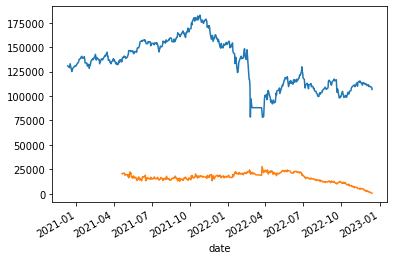

In [35]:
riu2[TARGET_COLUMN].plot()
riu2['center_call_prem'].plot()
plt.show()

In [37]:
riu2['center_call_intrinsic_value'] = (riu2[TARGET_COLUMN] - riu2['center_strike'])
riu2.loc[riu2['center_call_intrinsic_value'] < 0, 'center_call_intrinsic_value'] = 0

/var/folders/lp/88x61zk54x96rfk1cnvrknb80000gn/T/ipykernel_32200/2274180137.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fut_qrt['center_call_intrinsic_value'] = (fut_qrt[TARGET_COLUMN] - fut_qrt['center_strike'])


In [38]:
riu2['center_call_time_value'] = (riu2['center_call_prem'] - riu2['center_call_intrinsic_value'])

/var/folders/lp/88x61zk54x96rfk1cnvrknb80000gn/T/ipykernel_32200/3420162400.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fut_qrt['center_call_time_value'] = (fut_qrt['center_call_prem'] - fut_qrt['center_call_intrinsic_value'])


In [39]:
#riu2['center_call_prem'] = riu2['center_call_prem'].fillna(riu2['center_call_intrinsic_value'])

In [40]:
riu2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 509 entries, 2020-12-11 to 2022-12-14
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   adjp                         509 non-null    int64         
 1   return                       508 non-null    float64       
 2   ln_r                         508 non-null    float64       
 3   volatility_20                489 non-null    float64       
 4   volatility_60                449 non-null    float64       
 5   exp_date                     509 non-null    datetime64[ns]
 6   till_exp                     509 non-null    int64         
 7   T                            509 non-null    float64       
 8   center_strike                509 non-null    int64         
 9   center_call_prem             420 non-null    float64       
 10  center_call_intrinsic_value  509 non-null    int64         
 11  center_call_time_value    

In [41]:
riu2 = riu2.dropna()

In [42]:
def get_call_sigmas(row):
    return implied_volatility.iterate(row[TARGET_COLUMN], row['center_strike'], row['T'], 'call', 
                                                    row['center_call_prem']) * 100

In [43]:
riu2['center_call_sigma'] = riu2.apply(get_call_sigmas, axis = 1)

In [44]:
# def get_put_center(row):
#     date = row.name
#     return options_qrt_df[(options_qrt_df.index == date) &
#                (options_qrt_df['strike'] == row['center_strike']) &
#                (options_qrt_df['option_type'] == 'put')][TARGET_COLUMN][0]

# riu2['center_put_prem'] = riu2.apply(get_put_center, axis = 1)

# riu2['center_put_intrinsic_value'] = (riu2['center_strike'] - riu2[TARGET_COLUMN])
# riu2.loc[riu2['center_put_intrinsic_value'] < 0, 'center_put_intrinsic_value'] = 0

# riu2['center_put_time_value'] = (riu2['center_put_prem'] - riu2['center_put_intrinsic_value'])

# #riu2['center_put_prem'] = riu2['center_put_prem'].fillna(riu2['center_put_intrinsic_value'])

# def get_put_sigmas(row):
#     return implied_volatility.iterate(row[TARGET_COLUMN], row['center_strike'], row['T'], 'put', 
#                                                     row['center_put_prem'])*100

# riu2['center_put_sigma'] = riu2.apply(get_put_sigmas, axis = 1)

In [45]:
riu2

,adjp,return,ln_r,volatility_20,volatility_60,exp_date,till_exp,T,center_strike,center_call_prem,center_call_intrinsic_value,center_call_time_value,center_call_sigma
date,,,,,,,,,,,,,
2021-04-21,136540,1.012608,0.012529,20.570020,24.866584,2022-12-15,603,1.652055,137500,20700.0,0,20700.0,30.331470
2021-04-22,139450,1.021312,0.021089,21.324924,24.873656,2022-12-15,602,1.649315,140000,20240.0,0,20240.0,28.819324
2021-04-23,139000,0.996773,-0.003232,21.187609,24.860309,2022-12-15,601,1.646575,140000,20610.0,0,20610.0,29.734829
2021-04-26,140960,1.014101,0.014002,21.353199,24.848218,2022-12-15,598,1.638356,140000,21130.0,960,20170.0,28.946512
2021-04-27,139900,0.992480,-0.007548,21.617495,23.882835,2022-12-15,597,1.635616,140000,20730.0,0,20730.0,29.271866
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-08,109720,0.996006,-0.004002,17.559536,35.296810,2022-12-15,7,0.019178,110000,1620.0,0,1620.0,28.940915
2022-12-09,109890,1.001549,0.001548,17.515427,35.153537,2022-12-15,6,0.016438,110000,1520.0,0,1520.0,27.997543
2022-12-12,109130,0.993084,-0.006940,17.190332,35.167465,2022-12-15,3,0.008219,110000,830.0,0,830.0,30.681654


In [46]:
riu2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420 entries, 2021-04-21 to 2022-12-14
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   adjp                         420 non-null    int64         
 1   return                       420 non-null    float64       
 2   ln_r                         420 non-null    float64       
 3   volatility_20                420 non-null    float64       
 4   volatility_60                420 non-null    float64       
 5   exp_date                     420 non-null    datetime64[ns]
 6   till_exp                     420 non-null    int64         
 7   T                            420 non-null    float64       
 8   center_strike                420 non-null    int64         
 9   center_call_prem             420 non-null    float64       
 10  center_call_intrinsic_value  420 non-null    int64         
 11  center_call_time_value    

<AxesSubplot:xlabel='date'>

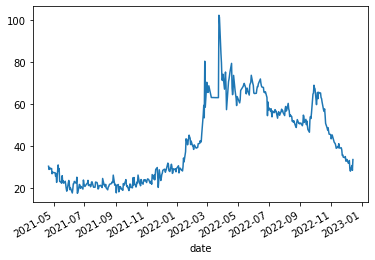

In [47]:
riu2['center_call_sigma'].plot()

<AxesSubplot:>

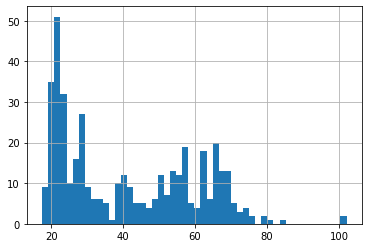

In [48]:
riu2['center_call_sigma'].hist(bins = 50)

In [49]:
# riu2['center_put_sigma'].plot()

# riu2['center_put_sigma'].hist(bins = 50)

# (riu2['center_call_sigma'] - riu2['center_put_sigma']).plot()

# (riu2['center_call_sigma'] - riu2['center_put_sigma']).hist(bins = 50)

<AxesSubplot:xlabel='till_exp', ylabel='center_call_sigma'>

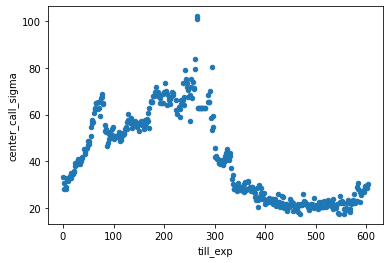

In [50]:
riu2.plot(kind = 'scatter', x = 'till_exp', y = 'center_call_sigma')

<AxesSubplot:xlabel='return', ylabel='center_call_sigma'>

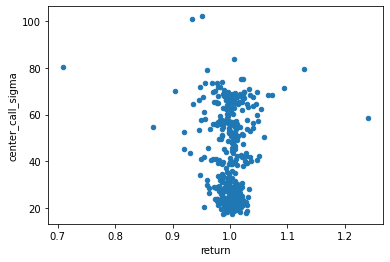

In [51]:
riu2.plot(kind = 'scatter', x = 'return', y = 'center_call_sigma')

In [52]:
#riu2['return'] = riu2['return'].fillna(1)

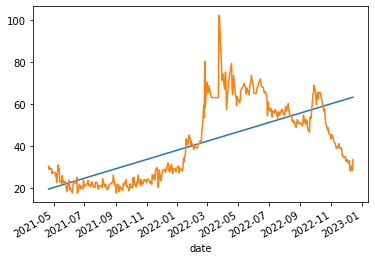

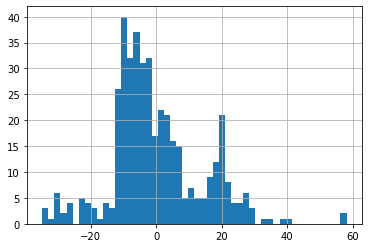

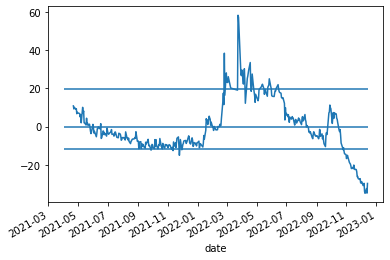

In [53]:
X = riu2[['till_exp']]
y = riu2['center_call_sigma']
X1 = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
w_ = (np.linalg.inv(X1.T.dot(X1)).dot(X1.T)).dot(y)
w = w_[1:]
w0 = w_[0]
preds = X.dot(w) + w0

preds.plot()
y.plot()
plt.show()

resids = (y - preds)
resids.hist(bins = 50)
plt.show()

resids.plot()
plt.hlines(0, '2021-04-01', '2022-12-15')
plt.hlines(resids.quantile(.1), '2021-04-01', '2022-12-15')
plt.hlines(resids.quantile(.9), '2021-04-01', '2022-12-15')
plt.show()

In [54]:
mean_absolute_error(y, preds)

10.542829957059945

In [55]:
r2_score(y, preds)

0.4595236308021401

In [56]:
# X = riu2[['return']]
# y = riu2['center_call_sigma']
# X1 = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

In [57]:
# w_ = (np.linalg.inv(X1.T.dot(X1)).dot(X1.T)).dot(y)

# w = w_[1:]

# w0 = w_[0]

# preds = X.dot(w) + w0

# preds.plot()
# y.plot()
# plt.show()

# resids = (y - preds)
# resids.hist(bins = 50)
# plt.show()

# resids.plot()
# plt.hlines(0, '2022-09-15', '2022-12-15')
# plt.hlines(resids.quantile(.1), '2022-09-15', '2022-12-15')
# plt.hlines(resids.quantile(.9), '2022-09-15', '2022-12-15')
# plt.show()

In [58]:
acf = {}
for i in range(60):
    acf[i] = riu2['center_call_sigma'].corr(riu2['center_call_sigma'].shift(i))

<AxesSubplot:>

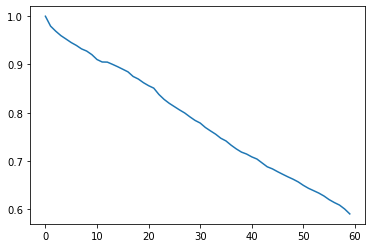

In [59]:
pd.Series(acf).plot()

In [60]:
riu2

,adjp,return,ln_r,volatility_20,volatility_60,exp_date,till_exp,T,center_strike,center_call_prem,center_call_intrinsic_value,center_call_time_value,center_call_sigma
date,,,,,,,,,,,,,
2021-04-21,136540,1.012608,0.012529,20.570020,24.866584,2022-12-15,603,1.652055,137500,20700.0,0,20700.0,30.331470
2021-04-22,139450,1.021312,0.021089,21.324924,24.873656,2022-12-15,602,1.649315,140000,20240.0,0,20240.0,28.819324
2021-04-23,139000,0.996773,-0.003232,21.187609,24.860309,2022-12-15,601,1.646575,140000,20610.0,0,20610.0,29.734829
2021-04-26,140960,1.014101,0.014002,21.353199,24.848218,2022-12-15,598,1.638356,140000,21130.0,960,20170.0,28.946512
2021-04-27,139900,0.992480,-0.007548,21.617495,23.882835,2022-12-15,597,1.635616,140000,20730.0,0,20730.0,29.271866
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-08,109720,0.996006,-0.004002,17.559536,35.296810,2022-12-15,7,0.019178,110000,1620.0,0,1620.0,28.940915
2022-12-09,109890,1.001549,0.001548,17.515427,35.153537,2022-12-15,6,0.016438,110000,1520.0,0,1520.0,27.997543
2022-12-12,109130,0.993084,-0.006940,17.190332,35.167465,2022-12-15,3,0.008219,110000,830.0,0,830.0,30.681654


In [61]:
riu2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420 entries, 2021-04-21 to 2022-12-14
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   adjp                         420 non-null    int64         
 1   return                       420 non-null    float64       
 2   ln_r                         420 non-null    float64       
 3   volatility_20                420 non-null    float64       
 4   volatility_60                420 non-null    float64       
 5   exp_date                     420 non-null    datetime64[ns]
 6   till_exp                     420 non-null    int64         
 7   T                            420 non-null    float64       
 8   center_strike                420 non-null    int64         
 9   center_call_prem             420 non-null    float64       
 10  center_call_intrinsic_value  420 non-null    int64         
 11  center_call_time_value    

In [ ]:
%%time
riu2 = riu2.apply(compute_ivs, axis = 1)

In [ ]:
riu2 = riu2[riu2.index <= '2022-09-10']

In [ ]:
riu2.tail()

In [ ]:
riu2.info()

In [ ]:
riu2.isna().sum()

In [ ]:
riu2.describe()

In [ ]:
vola_smile_call, vola_smile_put = vola_smile_df(riu2)

In [ ]:
vola_smile_call.tail()

In [ ]:
vola_smile_call.info()

In [ ]:
vola_smile_call.isna().sum()

In [ ]:
vola_smile_call.describe()

In [ ]:
vola_smile_put.tail()

In [ ]:
vola_smile_put.info()

In [ ]:
vola_smile_put.isna().sum()

In [ ]:
vola_smile_put.describe()

In [ ]:
f, ax = plt.subplots(5, 2, figsize = (15, 45))
i = 0
j = 0
for col in vola_smile_call.drop('center_iv_call', axis = 1).columns:
    vola_smile_call[col].plot(ax = ax[i][j], title = col)
    j+=1
    if j == 2:
        i+=1
        j = 0
plt.show()
vola_smile_call['center_iv_call'].plot(figsize = (15, 10), title = 'center_iv_call')
plt.show()

In [ ]:
f, ax = plt.subplots(5, 2, figsize = (15, 45))
i = 0
j = 0
for col in vola_smile_call.drop('center_iv_call', axis = 1).columns:
    title = col + ' minus center_iv_call'
    (vola_smile_call[col] - vola_smile_call['center_iv_call']).plot(ax = ax[i][j], title = title)
    j+=1
    if j == 2:
        i+=1
        j = 0
plt.show()

In [ ]:
f, ax = plt.subplots(5, 2, figsize = (15, 45))
i = 0
j = 0
for col in vola_smile_put.drop('center_iv_put', axis = 1).columns:
    vola_smile_put[col].plot(ax = ax[i][j], title = col)
    j+=1
    if j == 2:
        i+=1
        j = 0
plt.show()
vola_smile_put['center_iv_put'].plot(figsize = (15, 10), title = 'center_iv_put')
plt.show()

In [ ]:
f, ax = plt.subplots(5, 2, figsize = (15, 45))
i = 0
j = 0
for col in vola_smile_put.drop('center_iv_put', axis = 1).columns:
    title = col + ' minus center_iv_put'
    (vola_smile_put[col] - vola_smile_put['center_iv_put']).plot(ax = ax[i][j], title = title)
    j+=1
    if j == 2:
        i+=1
        j = 0
plt.show()

In [ ]:
for i in range(0, vola_smile_put.shape[0], int(vola_smile_put.shape[0]/10)):
    title = vola_smile_put.iloc[i].name
    vola_smile_put.iloc[i].plot(style = 'o-', figsize = (15, 10), grid = True, title = title)
    plt.show()